In [1]:
# Cell 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay
)
from sklearn.inspection import permutation_importance

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 110
RANDOM_STATE = 42

In [3]:
# Cell 2
df = pd.read_csv("/content/wdbc.csv", header=None)
df.columns = [
    "id","diagnosis",
    "radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean",
    "compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dimension_mean",
    "radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se",
    "concavity_se","concave_points_se","symmetry_se","fractal_dimension_se",
    "radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst",
    "compactness_worst","concavity_worst","concave_points_worst","symmetry_worst","fractal_dimension_worst"
]

# drop any accidental embedded header rows
bad = df["id"].astype(str).str.lower().eq("id") | df["diagnosis"].astype(str).str.lower().eq("diagnosis")
df = df.loc[~bad].reset_index(drop=True)

df.to_csv("dataset_before_cleaning.csv", index=False)
print("Saved: dataset_before_cleaning.csv   shape:", df.shape)
df.head(5)

Saved: dataset_before_cleaning.csv   shape: (570, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,0,1,2.00,3.00,4.00,5.0,6.00000,7.00000,8.0000,9.00000,...,22.00,23.00,24.00,25.0,26.0000,27.0000,28.0000,29.0000,30.0000,31.00000
1,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
2,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
3,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
4,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300


In [4]:
# Cell 3
# keep only B/M labels, map to 0/1
d = df["diagnosis"].astype(str).str.strip().str.upper()
df = df[d.isin(["B","M"])].copy()
df["diagnosis"] = (d.loc[df.index] == "M").astype(int)

# numeric features only
feat = [c for c in df.columns if c not in ("id","diagnosis")]
df[feat] = df[feat].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=feat)

# ensure unique patients
df = df[~df["id"].duplicated(keep="first")].reset_index(drop=True)

# split features/target and scale all features (for EDA / PCA etc.)
X_raw = df.drop(columns=["id","diagnosis"])
y = df["diagnosis"].astype(int)

scaler_all = StandardScaler().fit(X_raw)
X_scaled = pd.DataFrame(scaler_all.transform(X_raw), columns=X_raw.columns)
X_scaled["diagnosis"] = y.values
X_scaled.to_csv("dataset_after_cleaning.csv", index=False)

print("Final shape:", df.shape)                 # expected (569, 32)
print("Class counts:\n", y.value_counts().rename({0:"Benign",1:"Malignant"}))  # expected 357/212
X_scaled.head(5)

Final shape: (569, 32)
Class counts:
 diagnosis
Benign       357
Malignant    212
Name: count, dtype: int64


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,1
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,1
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,1
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,1
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,1


In [6]:
# Cell 4
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

/tmp/ipython-input-3630936375.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Blues_r")


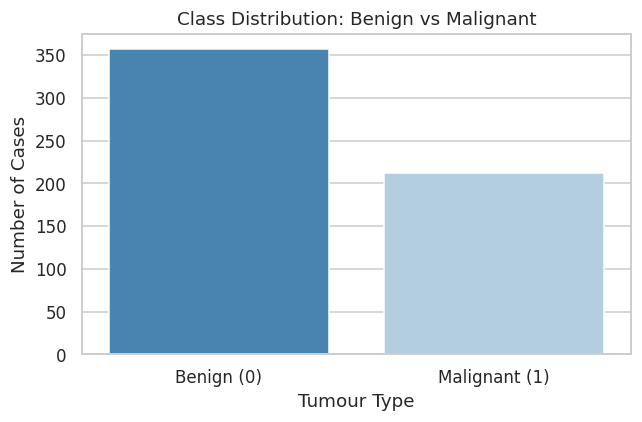

Counts:
Benign: 357 
Malignant: 212


In [7]:
# Cell 5.0

plt.figure(figsize=(6,4))
sns.countplot(x=y, palette="Blues_r")
plt.xticks([0, 1], ["Benign (0)", "Malignant (1)"])
plt.title("Class Distribution: Benign vs Malignant")
plt.xlabel("Tumour Type")
plt.ylabel("Number of Cases")
plt.tight_layout()
plt.show()

print("Counts:\nBenign:", sum(y==0), "\nMalignant:", sum(y==1))

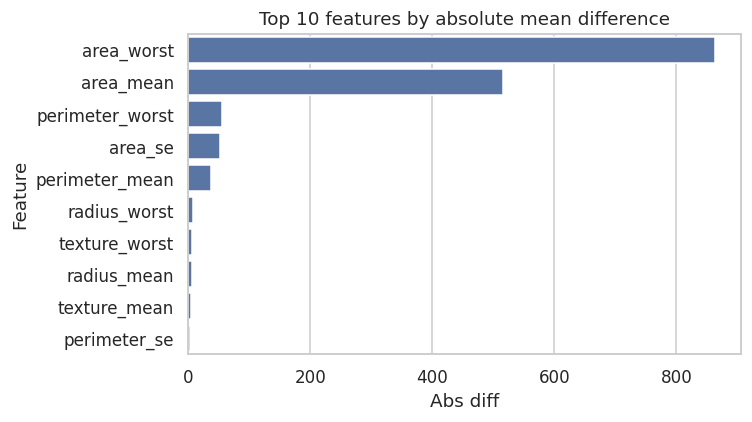

In [8]:
# Cell 5.1
tmp = X_raw.copy(); tmp["y"] = y.values
means = tmp.groupby("y").mean().T
means.columns = ["Benign","Malignant"]
top10 = (means["Malignant"] - means["Benign"]).abs().sort_values(ascending=False).head(10)
plt.figure(figsize=(7,4)); sns.barplot(x=top10.values, y=top10.index)
plt.title("Top 10 features by absolute mean difference"); plt.xlabel("Abs diff"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

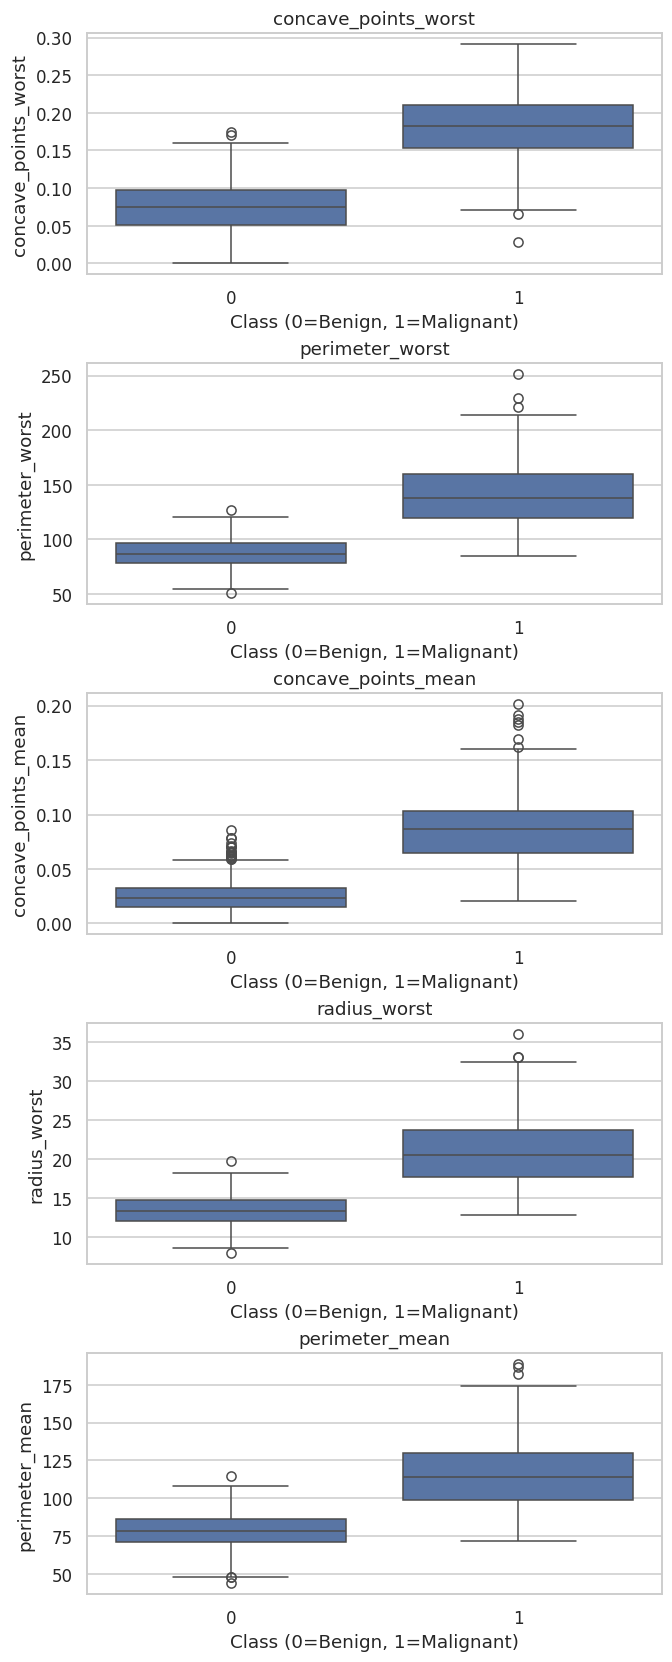

In [9]:
# Cell 5.2
corr_to_y = pd.Series(
    {c: np.corrcoef(X_raw[c], y)[0, 1] for c in X_raw.columns}
).abs().sort_values(ascending=False)

top5 = list(corr_to_y.head(5).index)

fig, axes = plt.subplots(len(top5), 1, figsize=(6, 3*len(top5)), constrained_layout=True)
if len(top5) == 1:
    axes = [axes]

for ax, col in zip(axes, top5):
    sns.boxplot(x=y, y=X_raw[col], ax=ax)
    ax.set_xlabel("Class (0=Benign, 1=Malignant)")
    ax.set_title(col)

plt.show()

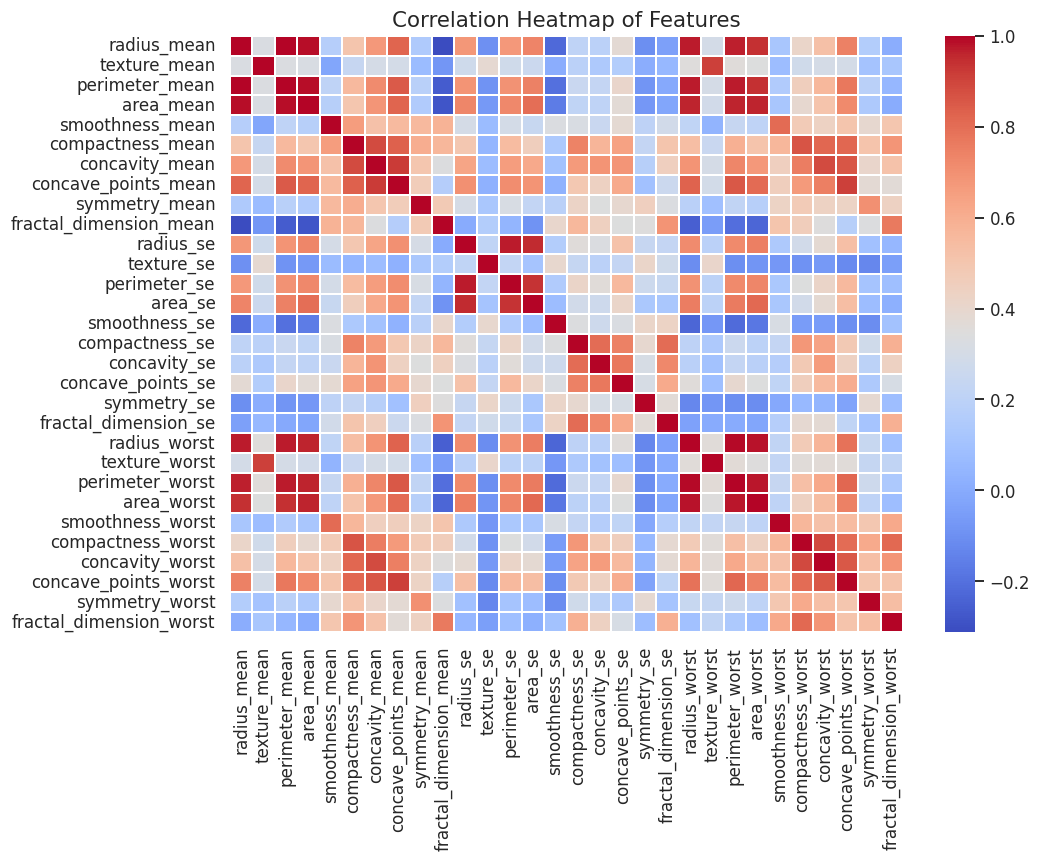

In [10]:
# Cell 5.3
corr = X_scaled.drop(columns=['diagnosis']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', linewidths=0.3)
plt.title('Correlation Heatmap of Features', fontsize=14)
plt.tight_layout()
plt.show()

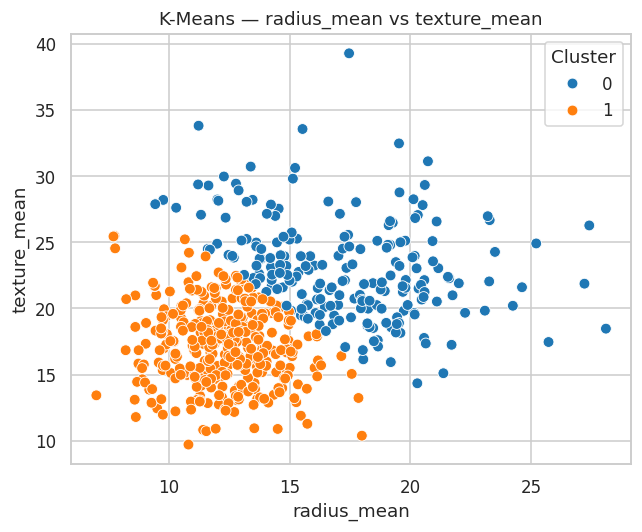

In [11]:
# Cell 5.4
X2 = X_raw[["radius_mean", "texture_mean"]]
X2s = StandardScaler().fit_transform(X2)

labels = KMeans(n_clusters=2, random_state=RANDOM_STATE).fit_predict(X2s)

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=X2["radius_mean"], y=X2["texture_mean"],
    hue=labels, palette=["#1f77b4", "#ff7f0e"], s=50
)
plt.title("K-Means — radius_mean vs texture_mean")
plt.xlabel("radius_mean")
plt.ylabel("texture_mean")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

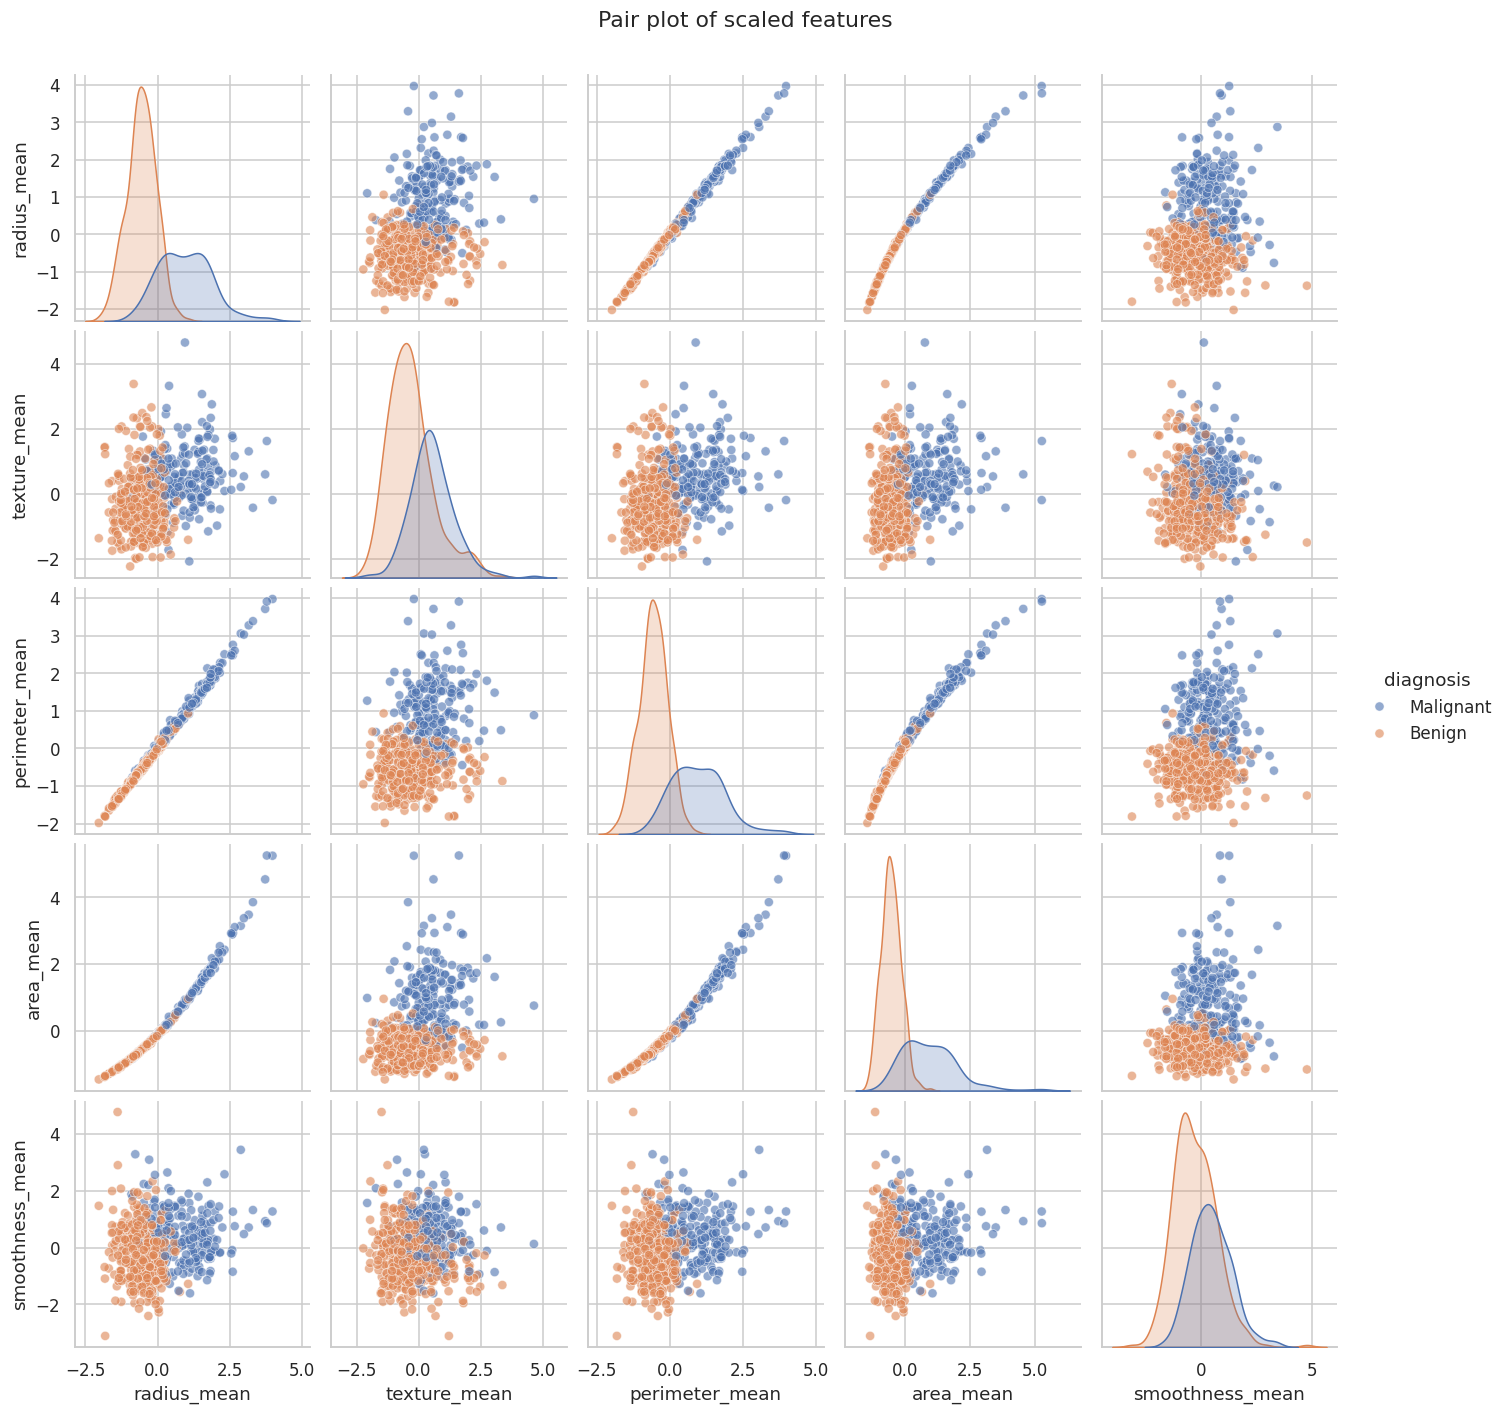

In [12]:
# Cell 5.5
pair_feats = ["radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean"]
pair = X_scaled[pair_feats + ["diagnosis"]].copy()
pair["diagnosis"] = pair["diagnosis"].map({0: "Benign", 1: "Malignant"})

g = sns.pairplot(pair, vars=pair_feats, hue="diagnosis", diag_kind="kde", plot_kws={"alpha": 0.6})
g.fig.suptitle("Pair plot of scaled features", y=1.03)
plt.show()

In [13]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "SVM_Linear": SVC(kernel='linear', probability=True),
    "SVM_Poly": SVC(kernel='poly', degree=3, probability=True),
    "SVM_RBF": SVC(kernel='rbf', probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
}
fitted = {name: clf.fit(X_train_std, y_train) for name, clf in models.items()}

print("Models successfully trained:")
for model_name in fitted.keys():
    print(" -", model_name)
print(f"\nTotal models trained: {len(fitted)}")

Models successfully trained:
 - LogisticRegression
 - SVM_Linear
 - SVM_Poly
 - SVM_RBF
 - RandomForest

Total models trained: 5


/tmp/ipython-input-964890334.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plt.figure(figsize=(8,4)); sns.barplot(x=acc_df["Accuracy"], y=acc_df.index, palette="Blues_r")


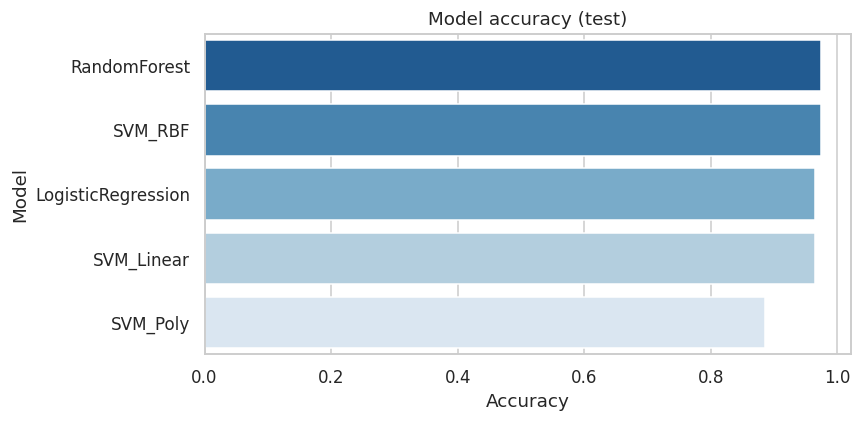

,Accuracy
RandomForest,0.974
SVM_RBF,0.974
LogisticRegression,0.965
SVM_Linear,0.965
SVM_Poly,0.886


In [14]:
# Cell 6.1 — Accuracy bar
acc = {n: accuracy_score(y_test, m.predict(X_test_std)) for n,m in fitted.items()}
acc_df = pd.DataFrame.from_dict(acc, orient="index", columns=["Accuracy"]).sort_values("Accuracy", ascending=False)
plt.figure(figsize=(8,4)); sns.barplot(x=acc_df["Accuracy"], y=acc_df.index, palette="Blues_r")
plt.title("Model accuracy (test)"); plt.xlabel("Accuracy"); plt.ylabel("Model"); plt.tight_layout(); plt.show()
acc_df.round(3)

In [15]:
# Cell 7
rows = []
for n, clf in fitted.items():
    p = clf.predict_proba(X_test_std)[:,1]
    yhat = (p>=0.5).astype(int)
    rows.append({"Model":n,
                 "Accuracy":accuracy_score(y_test,yhat),
                 "Precision":precision_score(y_test,yhat),
                 "Recall":recall_score(y_test,yhat),
                 "F1":f1_score(y_test,yhat),
                 "ROC_AUC":roc_auc_score(y_test,p)})
metrics_tbl = pd.DataFrame(rows).sort_values("ROC_AUC", ascending=False).reset_index(drop=True)
metrics_tbl.round(3)

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,SVM_Poly,0.947,1.000,0.857,0.923,0.997
1,LogisticRegression,0.965,0.975,0.929,0.951,0.996
2,SVM_RBF,0.965,0.952,0.952,0.952,0.995
3,RandomForest,0.974,1.000,0.929,0.963,0.994
4,SVM_Linear,0.956,1.000,0.881,0.937,0.991


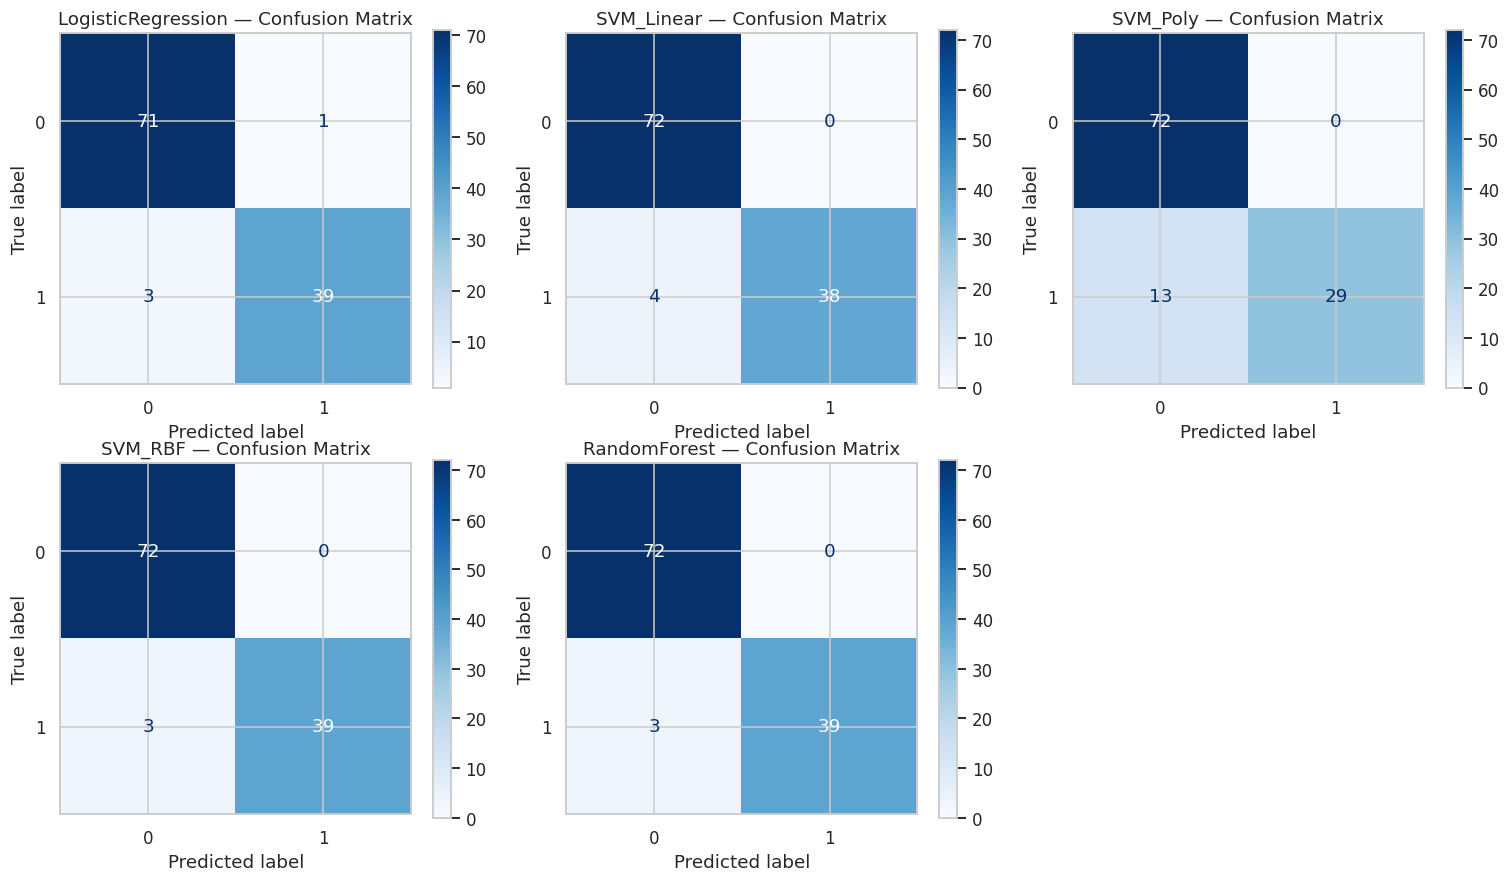

In [16]:
# Cell 8
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import math

# Determine layout (3 per row for readability)
cols = 3
rows = math.ceil(len(fitted) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows))
axes = axes.ravel()

for i, (name, model) in enumerate(fitted.items()):
    ConfusionMatrixDisplay.from_estimator(model, X_test_std, y_test, ax=axes[i], cmap="Blues", values_format="d")
    axes[i].set_title(f"{name} — Confusion Matrix")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


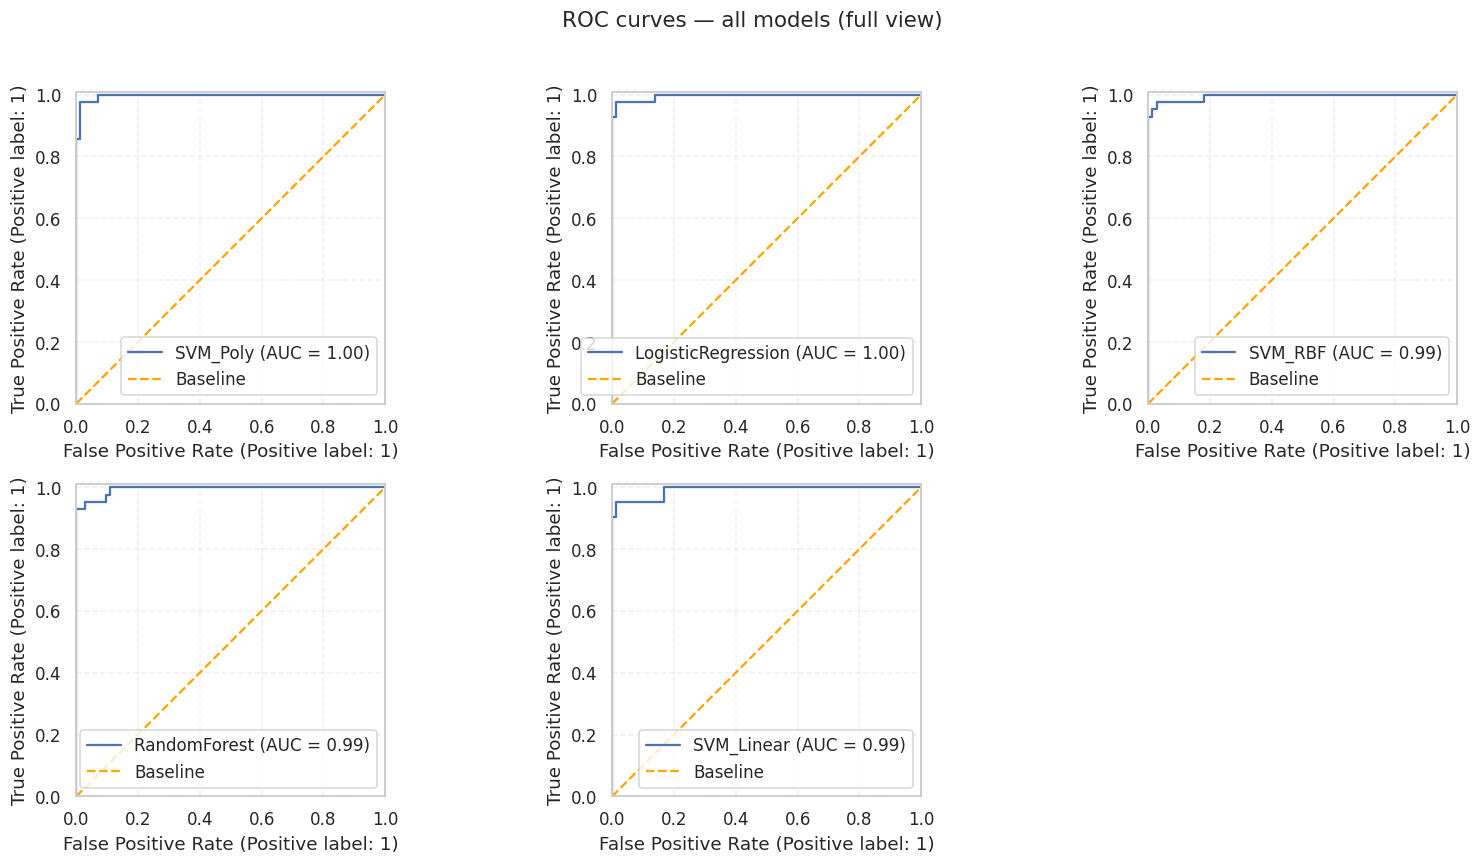

In [17]:
# Cell 9
names = sorted(fitted.keys(), key=lambda k: roc_auc_score(y_test, fitted[k].predict_proba(X_test_std)[:,1]), reverse=True)
cols = 3; rows = int(np.ceil(len(names)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows)); axes = axes.ravel()

for i, n in enumerate(names):
    ax = axes[i]
    RocCurveDisplay.from_estimator(fitted[n], X_test_std, y_test, ax=ax, name=f"{n}")
    ax.plot([0,1],[0,1],"--", color="orange", label="Baseline")
    ax.set_xlim(0,1); ax.set_ylim(0,1.01); ax.grid(True, ls="--", alpha=0.3); ax.legend(loc="lower right")

for ax in axes[len(names):]: fig.delaxes(ax)
fig.suptitle("ROC curves — all models (full view)", fontsize=14); fig.tight_layout(rect=[0,0,1,0.96]); plt.show()

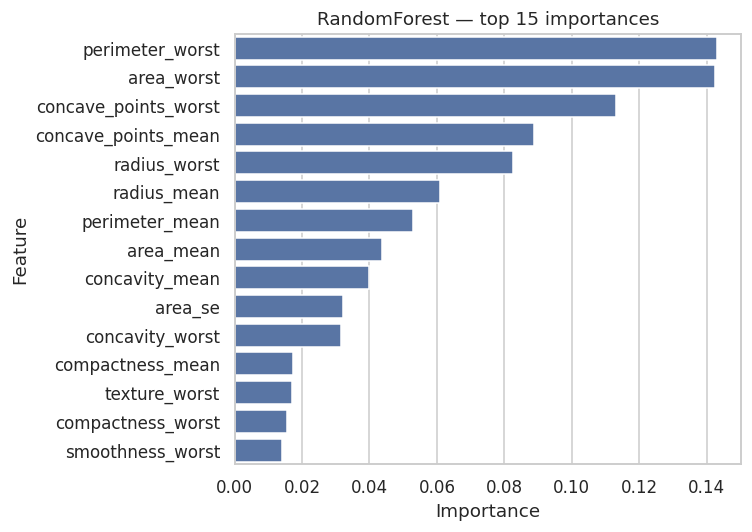

In [18]:
# Cell 10
rf = fitted["RandomForest"]
imp = pd.Series(rf.feature_importances_, index=X_raw.columns).sort_values(ascending=False).head(15)
plt.figure(figsize=(7,5)); sns.barplot(x=imp.values, y=imp.index); plt.title("RandomForest — top 15 importances")
plt.xlabel("Importance"); plt.ylabel("Feature"); plt.tight_layout(); plt.show()